In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import argparse
import os
import tqdm
import scipy.ndimage as nd
from torchvision import transforms

In [2]:
if torch.cuda.is_available():  
    device = "cuda:0"
else:  
    device = "cpu"
device = torch.device(device)
print(device)

cuda:0


In [3]:
class UnNormalize(object): #from https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

mean = torch.tensor([0.485, 0.456, 0.406], device=device)
std = torch.tensor([0.229, 0.224, 0.225], device=device)

toTensor = transforms.ToTensor()
toPIL = transforms.ToPILImage()
normalize = transforms.Normalize(mean, std)
unnormalize = UnNormalize(mean, std)

In [4]:
layer_cut = 27
network = models.vgg19(pretrained=True).cuda()
for param in network.parameters():
    param.require_grad = False
layers = list(network.features.children())
network = nn.Sequential(*layers[: (layer_cut + 1)])

(66, 45)
octave: 1
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
octave: 2
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
octave: 3
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
octave: 4
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
octave: 5
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
octave: 6
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
octave: 7
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
octave: 8
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
(1122, 757)


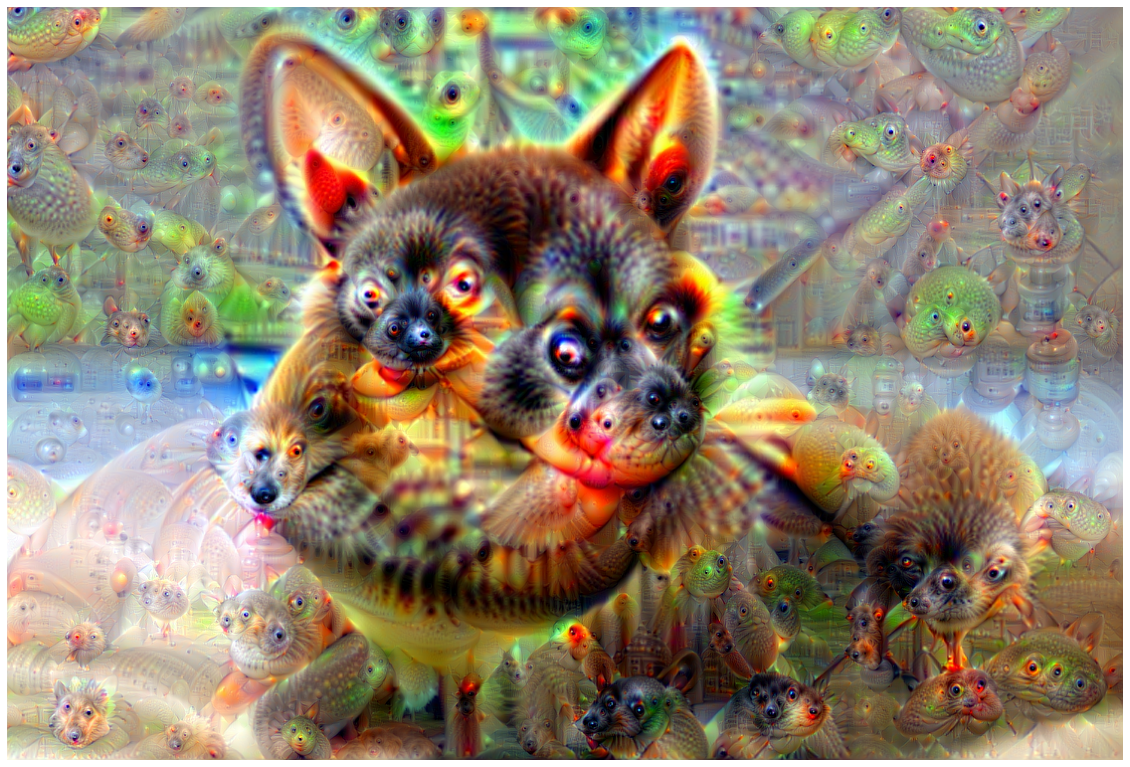

In [13]:
image_name = "test2.jpg"

learning_rate = 0.005

image = Image.open(image_name)
print(image.size)
image = toTensor(image).to(device)
image = normalize(image)
image = image.unsqueeze(0) #single image to batch of size one [3, width, height] -> [1, 3, width, height]
image = image.to(device)
image.requires_grad = True

octaves = 8
iterations = 20

for octave in range(octaves):
    print("octave: {}".format(octave + 1))
    if octave != 0:
        image.requires_grad = False
        image = torch.nn.functional.interpolate(image, scale_factor=1.5, mode="bicubic", align_corners=True, recompute_scale_factor=True)
        image.requires_grad = True
    for i in range(iterations):
        network.zero_grad()
        out = network(image)
        loss = out.norm()
        loss.backward()
        
        avg_grad = np.abs(image.grad.data.cpu().numpy()).mean()
#         avg_grad = 1
        
        image.data += (learning_rate / avg_grad) * image.grad.data # * (octaves / (octave + 1))
        image.grad.data.zero_()
        
        image.requires_grad = False
        image = unnormalize(image[0])
        image = image.clamp(0, 1)
        image = normalize(image)
        image = image.unsqueeze(0)
        image.requires_grad = True
        
        print("{} ".format(i + 1), end="")
    print()

image.requires_grad = False
image = unnormalize(image[0])
image = image.clamp(0, 1)

image = toPIL(image.cpu())

print(image.size)

plt.figure(figsize=(20, 20))
plt.axis("off")
plt.imshow(image)

image.save("out.jpg")